# Exploratory Data Analysis and Machine Learning Model Evaluation

## Import Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import warnings
warnings.filterwarnings(action='ignore')

# Load Dataset and Display Overview

In [2]:
diabetes_df = pd.read_csv("diabetes.csv")

In [3]:
diabetes_df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [4]:
# Rename the "DiabetesPedigreeFunction" column to "DPF"
diabetes_df.rename(columns={"DiabetesPedigreeFunction": "DPF"}, inplace=True)

# Style the first five rows with modified background and text colors
styled_df = diabetes_df.head().T.style.set_properties(**{'background-color': '#4CAF50',  # Green background
                                                           'color': '#FFFFFF',  # White text color
                                                           'border-color': 'white'})

styled_df

## Checking Missing Values and Data type

In [5]:
# Calculate the number of missing values in each column
missing_values_count = diabetes_df.isnull().sum()

# Display the result
print("Number of missing values in each column:")
print(missing_values_count)

Number of missing values in each column:
Pregnancies      0
Glucose          0
BloodPressure    0
SkinThickness    0
Insulin          0
BMI              0
DPF              0
Age              0
Outcome          0
dtype: int64


## Checking Target Imbalance

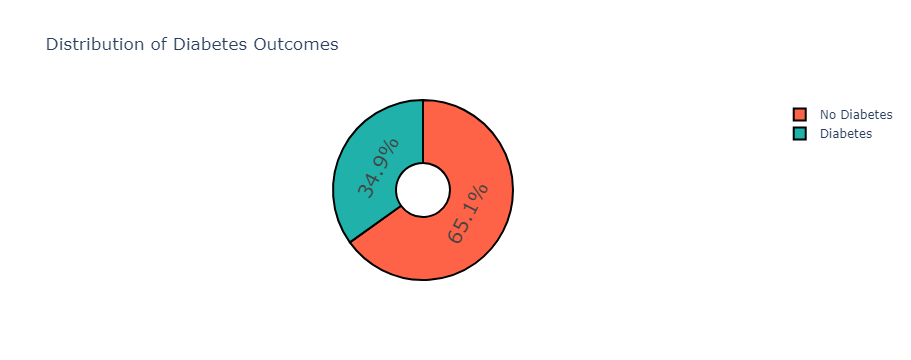

In [6]:
colors = ['#FF6347', '#20B2AA']  # Change colors
labels = ['No Diabetes', 'Diabetes']  # Change labels
values = diabetes_df['Outcome'].value_counts() / diabetes_df['Outcome'].shape[0]

# Use `hole` to create a donut-like pie chart
fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(
    title_text="Distribution of Diabetes Outcomes"
)
fig.show()

## Checking Statistics

In [7]:
def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

diabetes_df.describe().style.apply(highlight_min, props='color:Black;background-color:Grey', axis=0)

# Checking and Removing Outliers

In [8]:
feature_names = [cname for cname in diabetes_df.loc[:, :'Age'].columns]

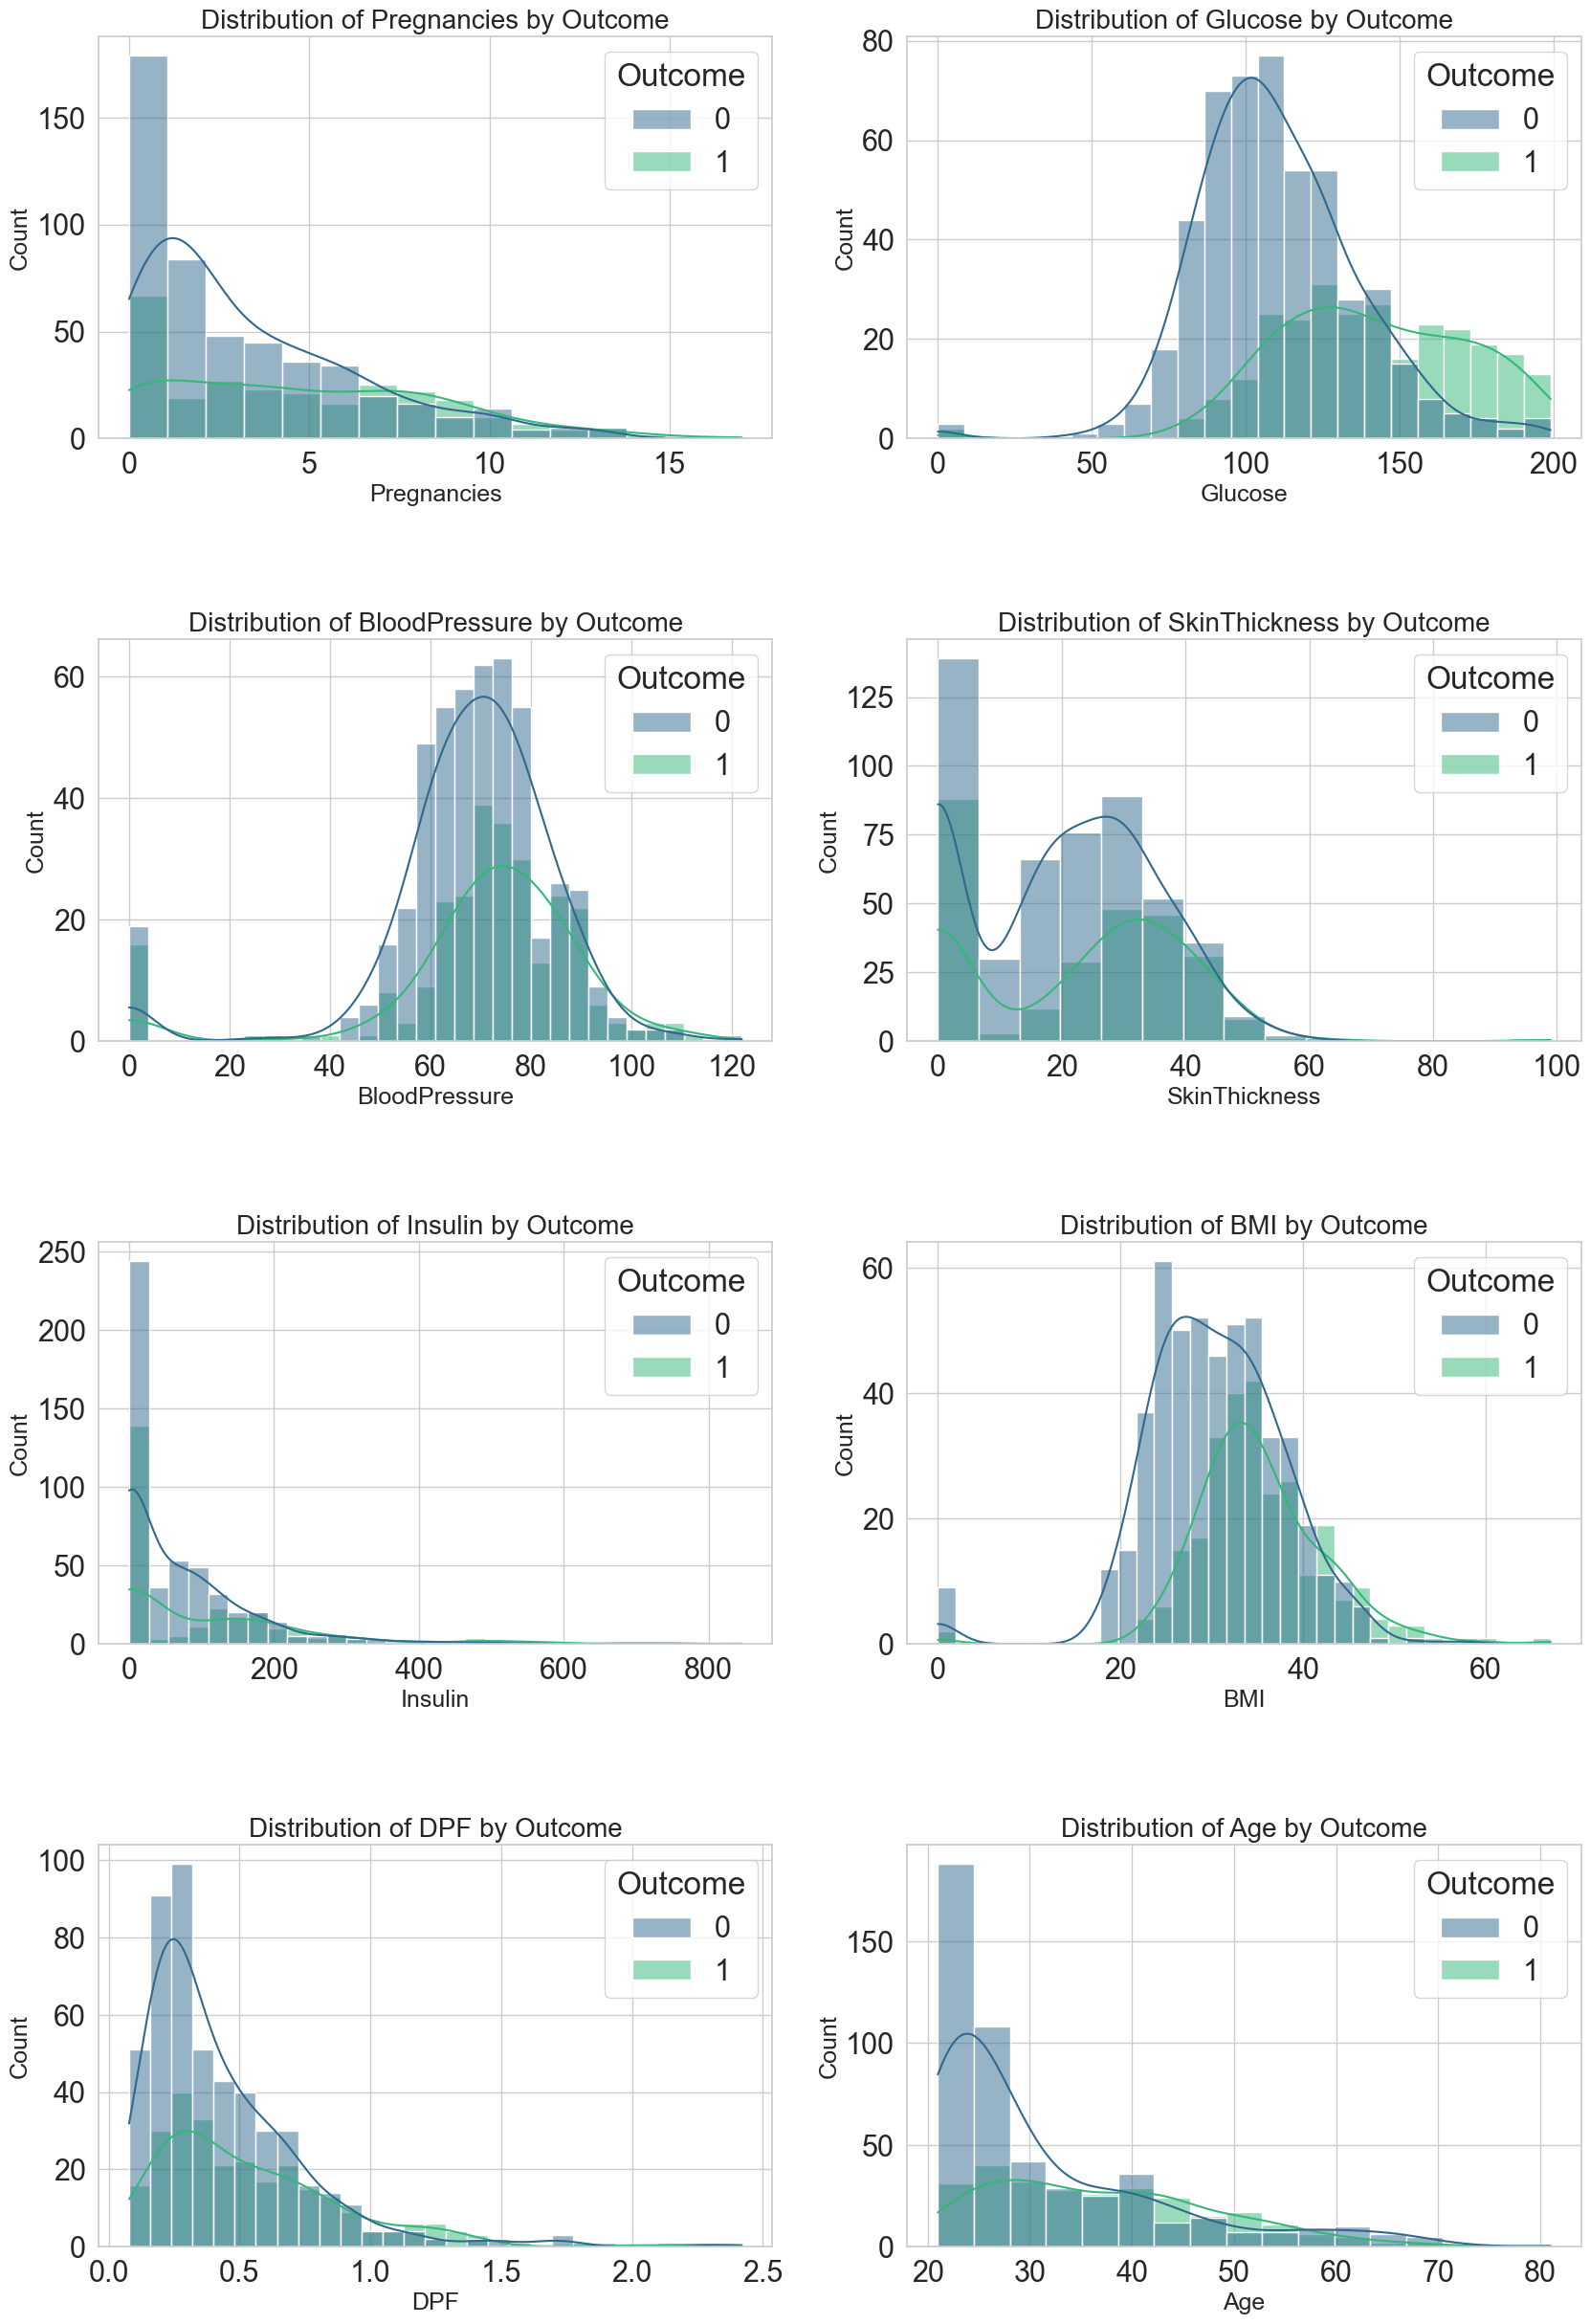

In [9]:
# Adjust the figure size and font scale
rcParams['figure.figsize'] = 20, 30
sns.set(font_scale=2)
sns.set_style("whitegrid")  # Use "whitegrid" for better visibility

# Create subplots
plt.subplots_adjust(hspace=0.5)

# Calculate the number of rows and columns dynamically based on the number of features
rows = (len(feature_names) + 1) // 2
i = 1

# Modify the loop for better subplot arrangement
for name in feature_names:
    plt.subplot(rows, 2, i)  # Adjust the number of rows and columns
    sns.histplot(data=diabetes_df, x=name, hue="Outcome", kde=True, palette="viridis")  # Change palette if needed
    plt.title(f'Distribution of {name} by Outcome', fontsize=20)
    plt.xlabel(name, fontsize=18)
    plt.ylabel('Count', fontsize=18)
    i = i + 1

# Show the plot
plt.show()

In [10]:
zero_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
total_count = diabetes_df['Glucose'].count()

for feature in zero_features:
    zero_count = diabetes_df[diabetes_df[feature] == 0][feature].count()
    percent_zero = 100 * zero_count / total_count
    print(f'{feature}: 0 number of cases {zero_count}, percentage is {percent_zero:.2f}%')

Pregnancies: 0 number of cases 111, percentage is 14.45%
Glucose: 0 number of cases 5, percentage is 0.65%
BloodPressure: 0 number of cases 35, percentage is 4.56%
SkinThickness: 0 number of cases 227, percentage is 29.56%
Insulin: 0 number of cases 374, percentage is 48.70%
BMI: 0 number of cases 11, percentage is 1.43%


In [11]:
# Calculate the mean excluding zeros
diabetes_mean = diabetes_df[zero_features].replace(0, np.nan).mean()

# Replace zeros with the mean
diabetes_df[zero_features] = diabetes_df[zero_features].replace(0, diabetes_mean)


In [41]:
X = diabetes_df.iloc[:,:-1]
y = diabetes_df.iloc[:,-1]

# Scaling

In [42]:
from sklearn.preprocessing import QuantileTransformer

# Assuming X is your feature matrix
# Replace this with your actual feature matrix
X = diabetes_df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']]

scaler = QuantileTransformer(n_quantiles=100, random_state=0, output_distribution='normal')
X_scaled = scaler.fit_transform(X)

# Convert the scaled data back to a DataFrame for better understanding
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Display the transformed data
print(X_scaled_df.head())

   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI
0     0.666564  0.873569      -0.076032       0.852495  0.165327  0.239380
1    -5.199338 -1.335178      -0.559592      -0.389414  0.165327 -0.799083
2     1.096804  1.708508      -0.731217       0.012660  0.165327 -1.434020
3    -5.199338 -1.167475      -0.559592      -0.799083 -0.947401 -0.567010
4     0.178175  0.574460      -2.405245       0.852495  0.965625  1.447963


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [50]:
def highlight_min(s, props=''):
    return np.where(s == np.nanmin(s.values), props, '')

X_train.describe().style.apply(highlight_min, props='color:Black;background-color:Grey', axis=0)

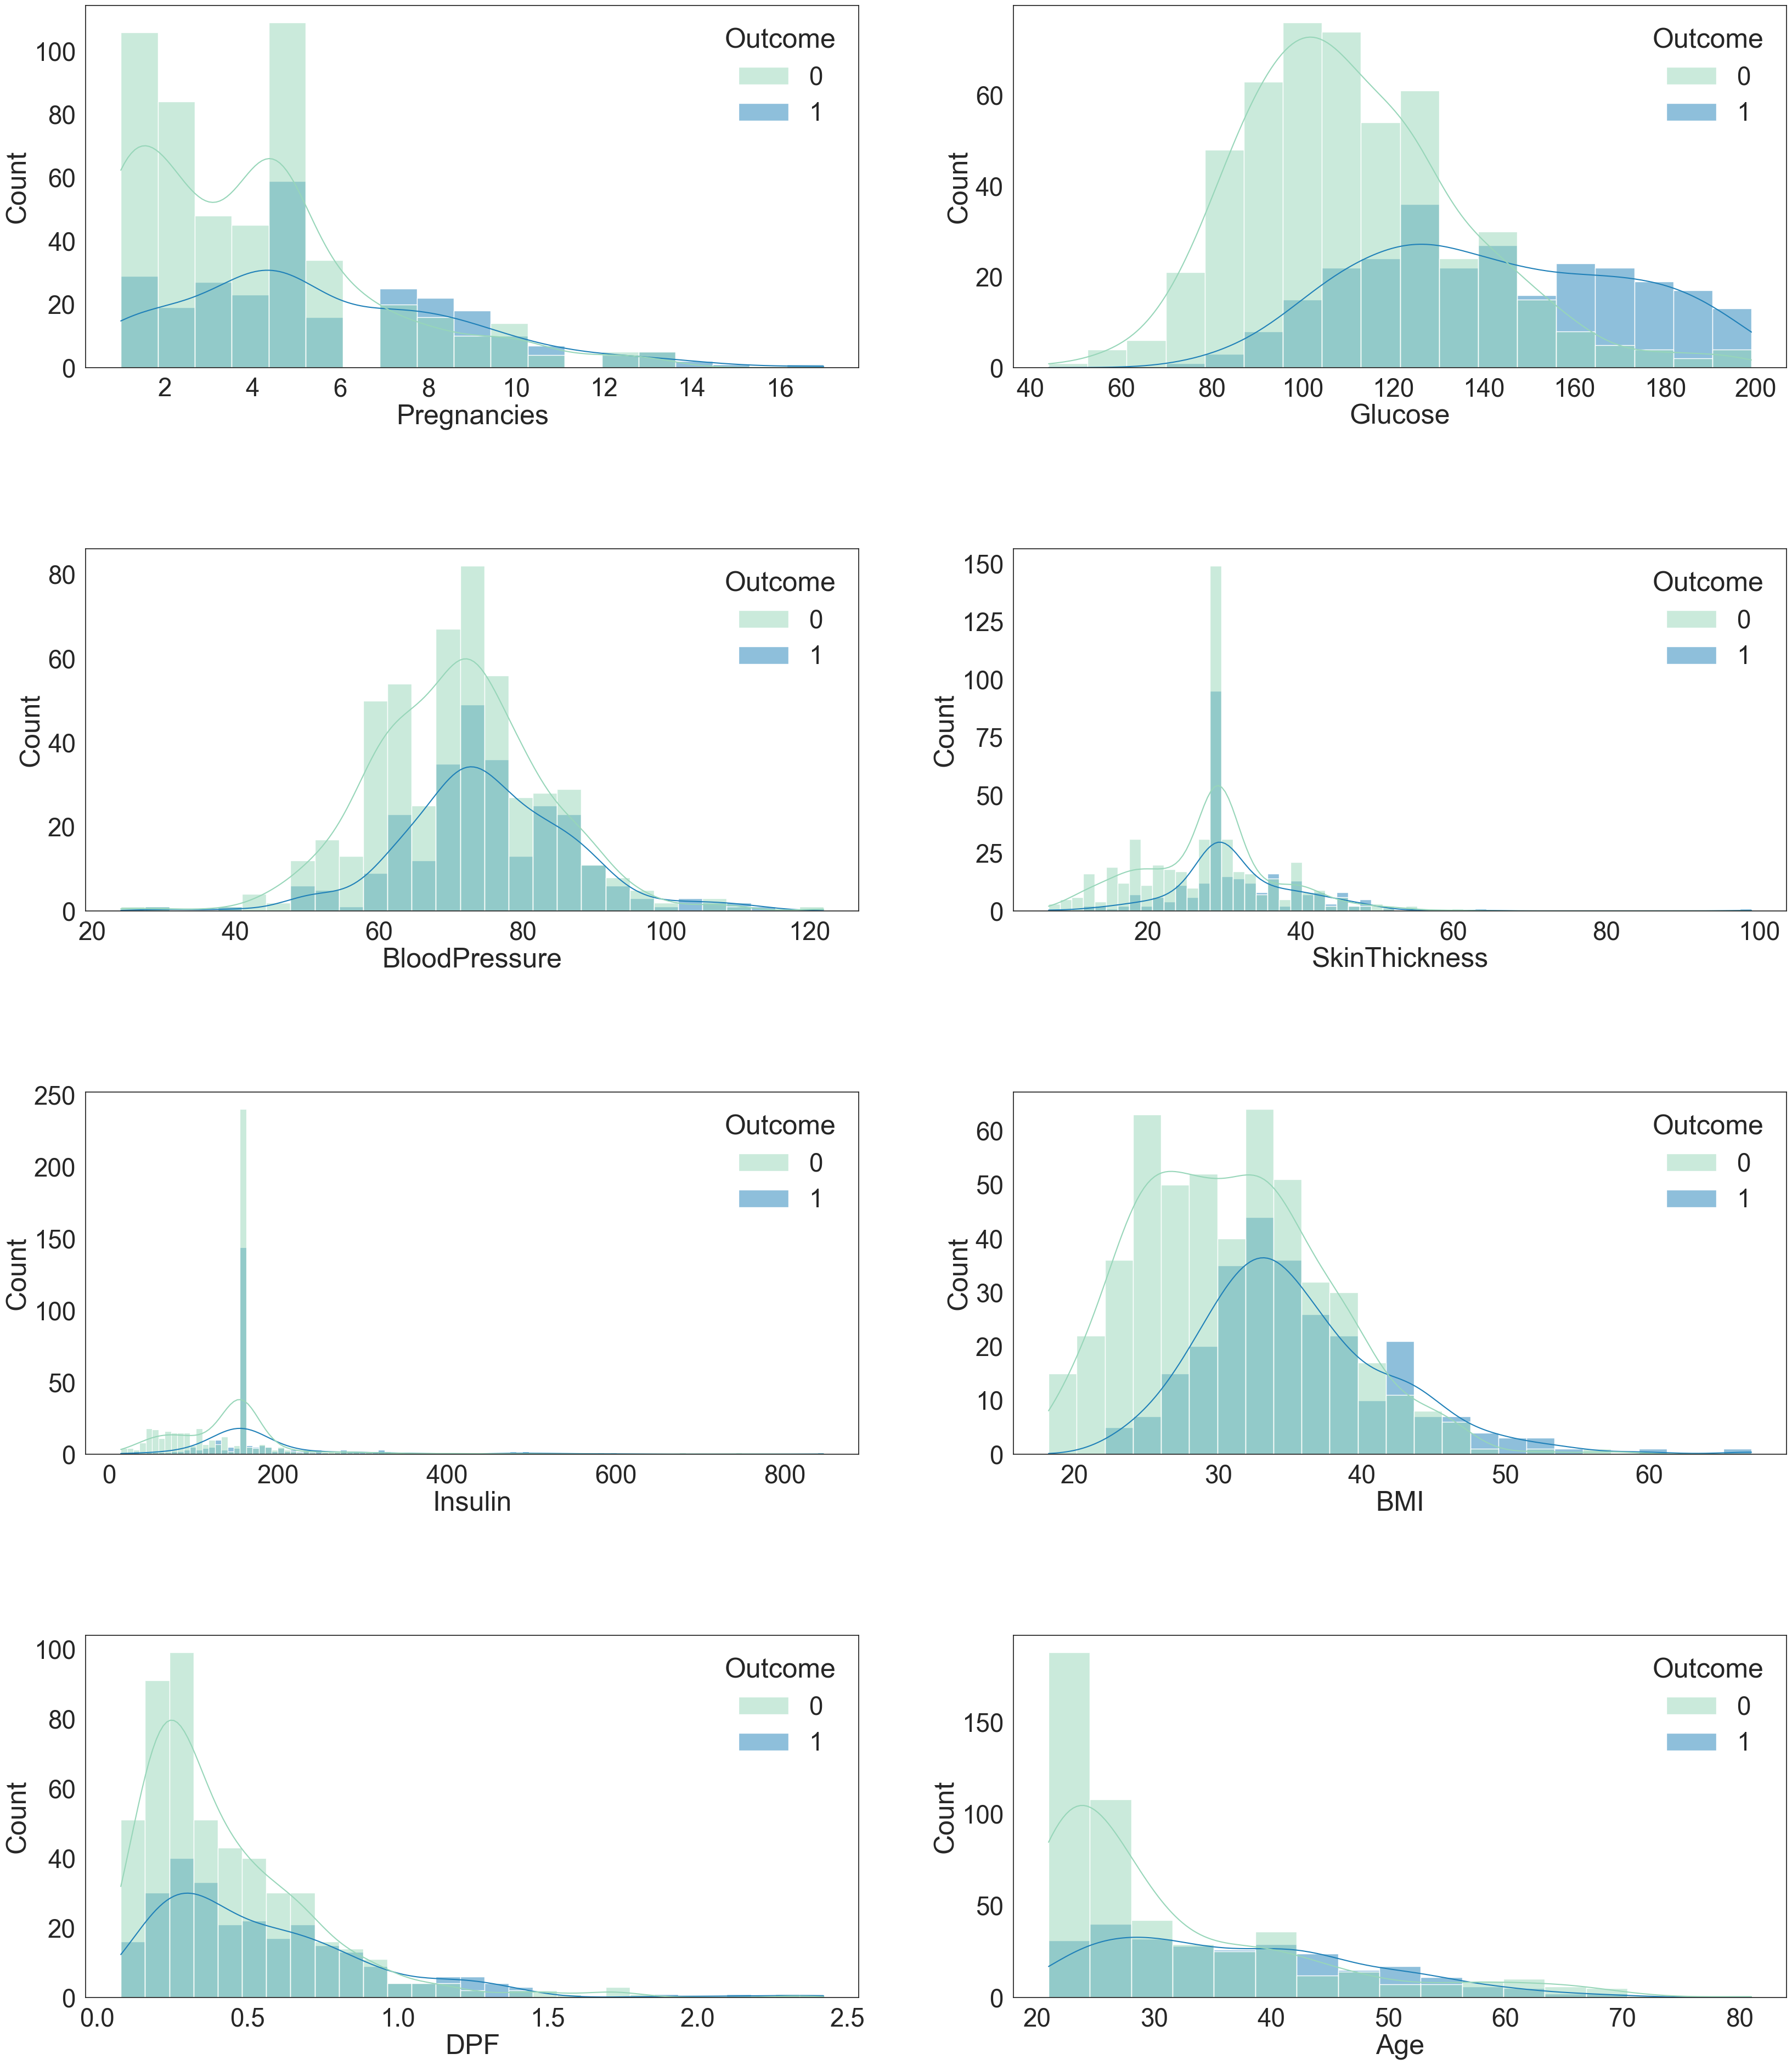

In [51]:
rcParams['figure.figsize'] = 40,60
sns.set(font_scale = 3)
sns.set_style("white")
sns.set_palette("bright")
plt.subplots_adjust(hspace=0.5)
i = 1;
for name in feature_names:
    plt.subplot(5,2,i)
    sns.histplot(data=diabetes_df, x=name, hue="Outcome",kde=True,palette="YlGnBu")
    i = i + 1

# Checking correlation between features

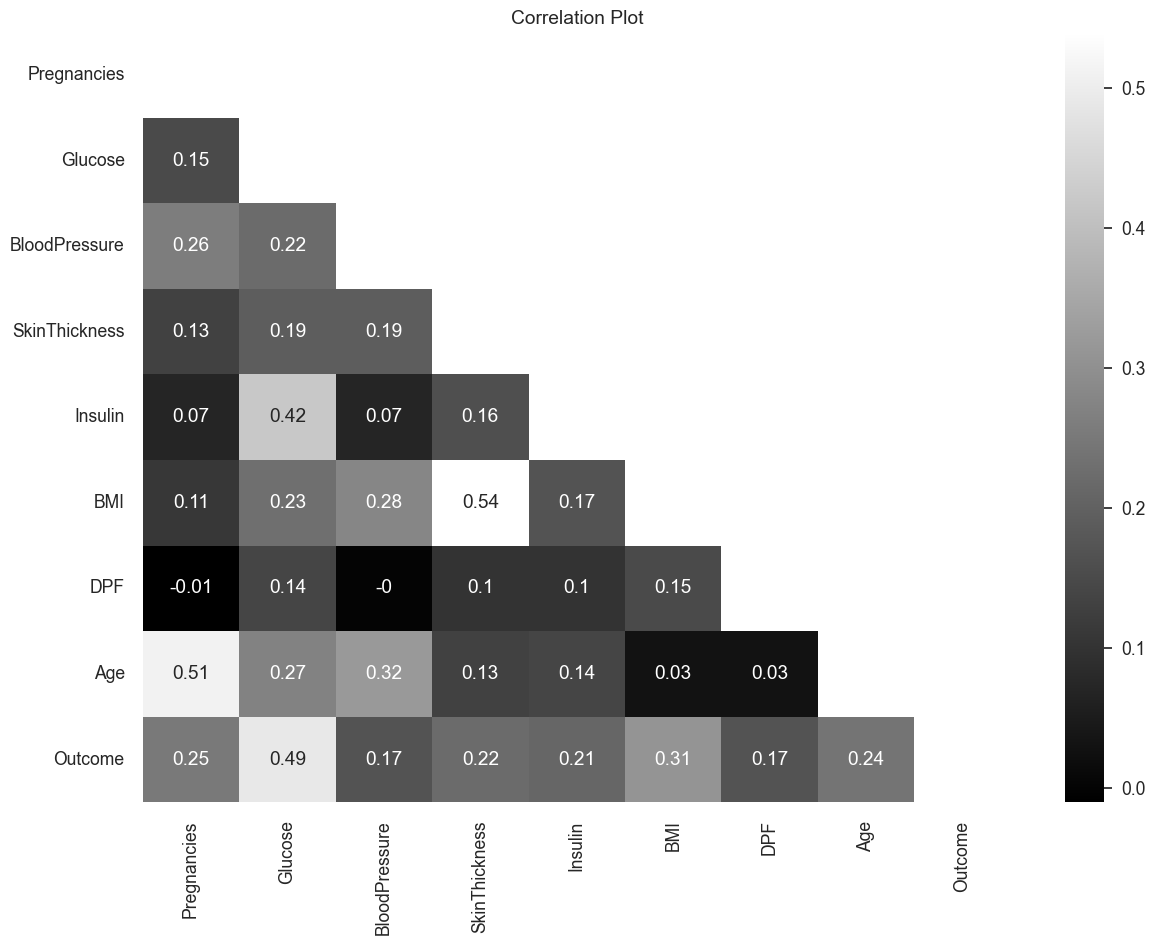

In [52]:
# Calculate the correlation matrix
corr = diabetes_df.corr().round(2)

# Set the font scale and figure size
sns.set(font_scale=1.15)
plt.figure(figsize=(14, 10))

# Set the color palette and style
sns.set_palette("bright")
sns.set_style("white")

# Create a mask to hide the upper triangle of the heatmap (since it's symmetric)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap
sns.heatmap(corr, annot=True, cmap='gist_yarg_r', mask=mask, cbar=True)

# Set the plot title
plt.title('Correlation Plot')

# Show the plot
plt.show()

<Figure size 1000x800 with 0 Axes>

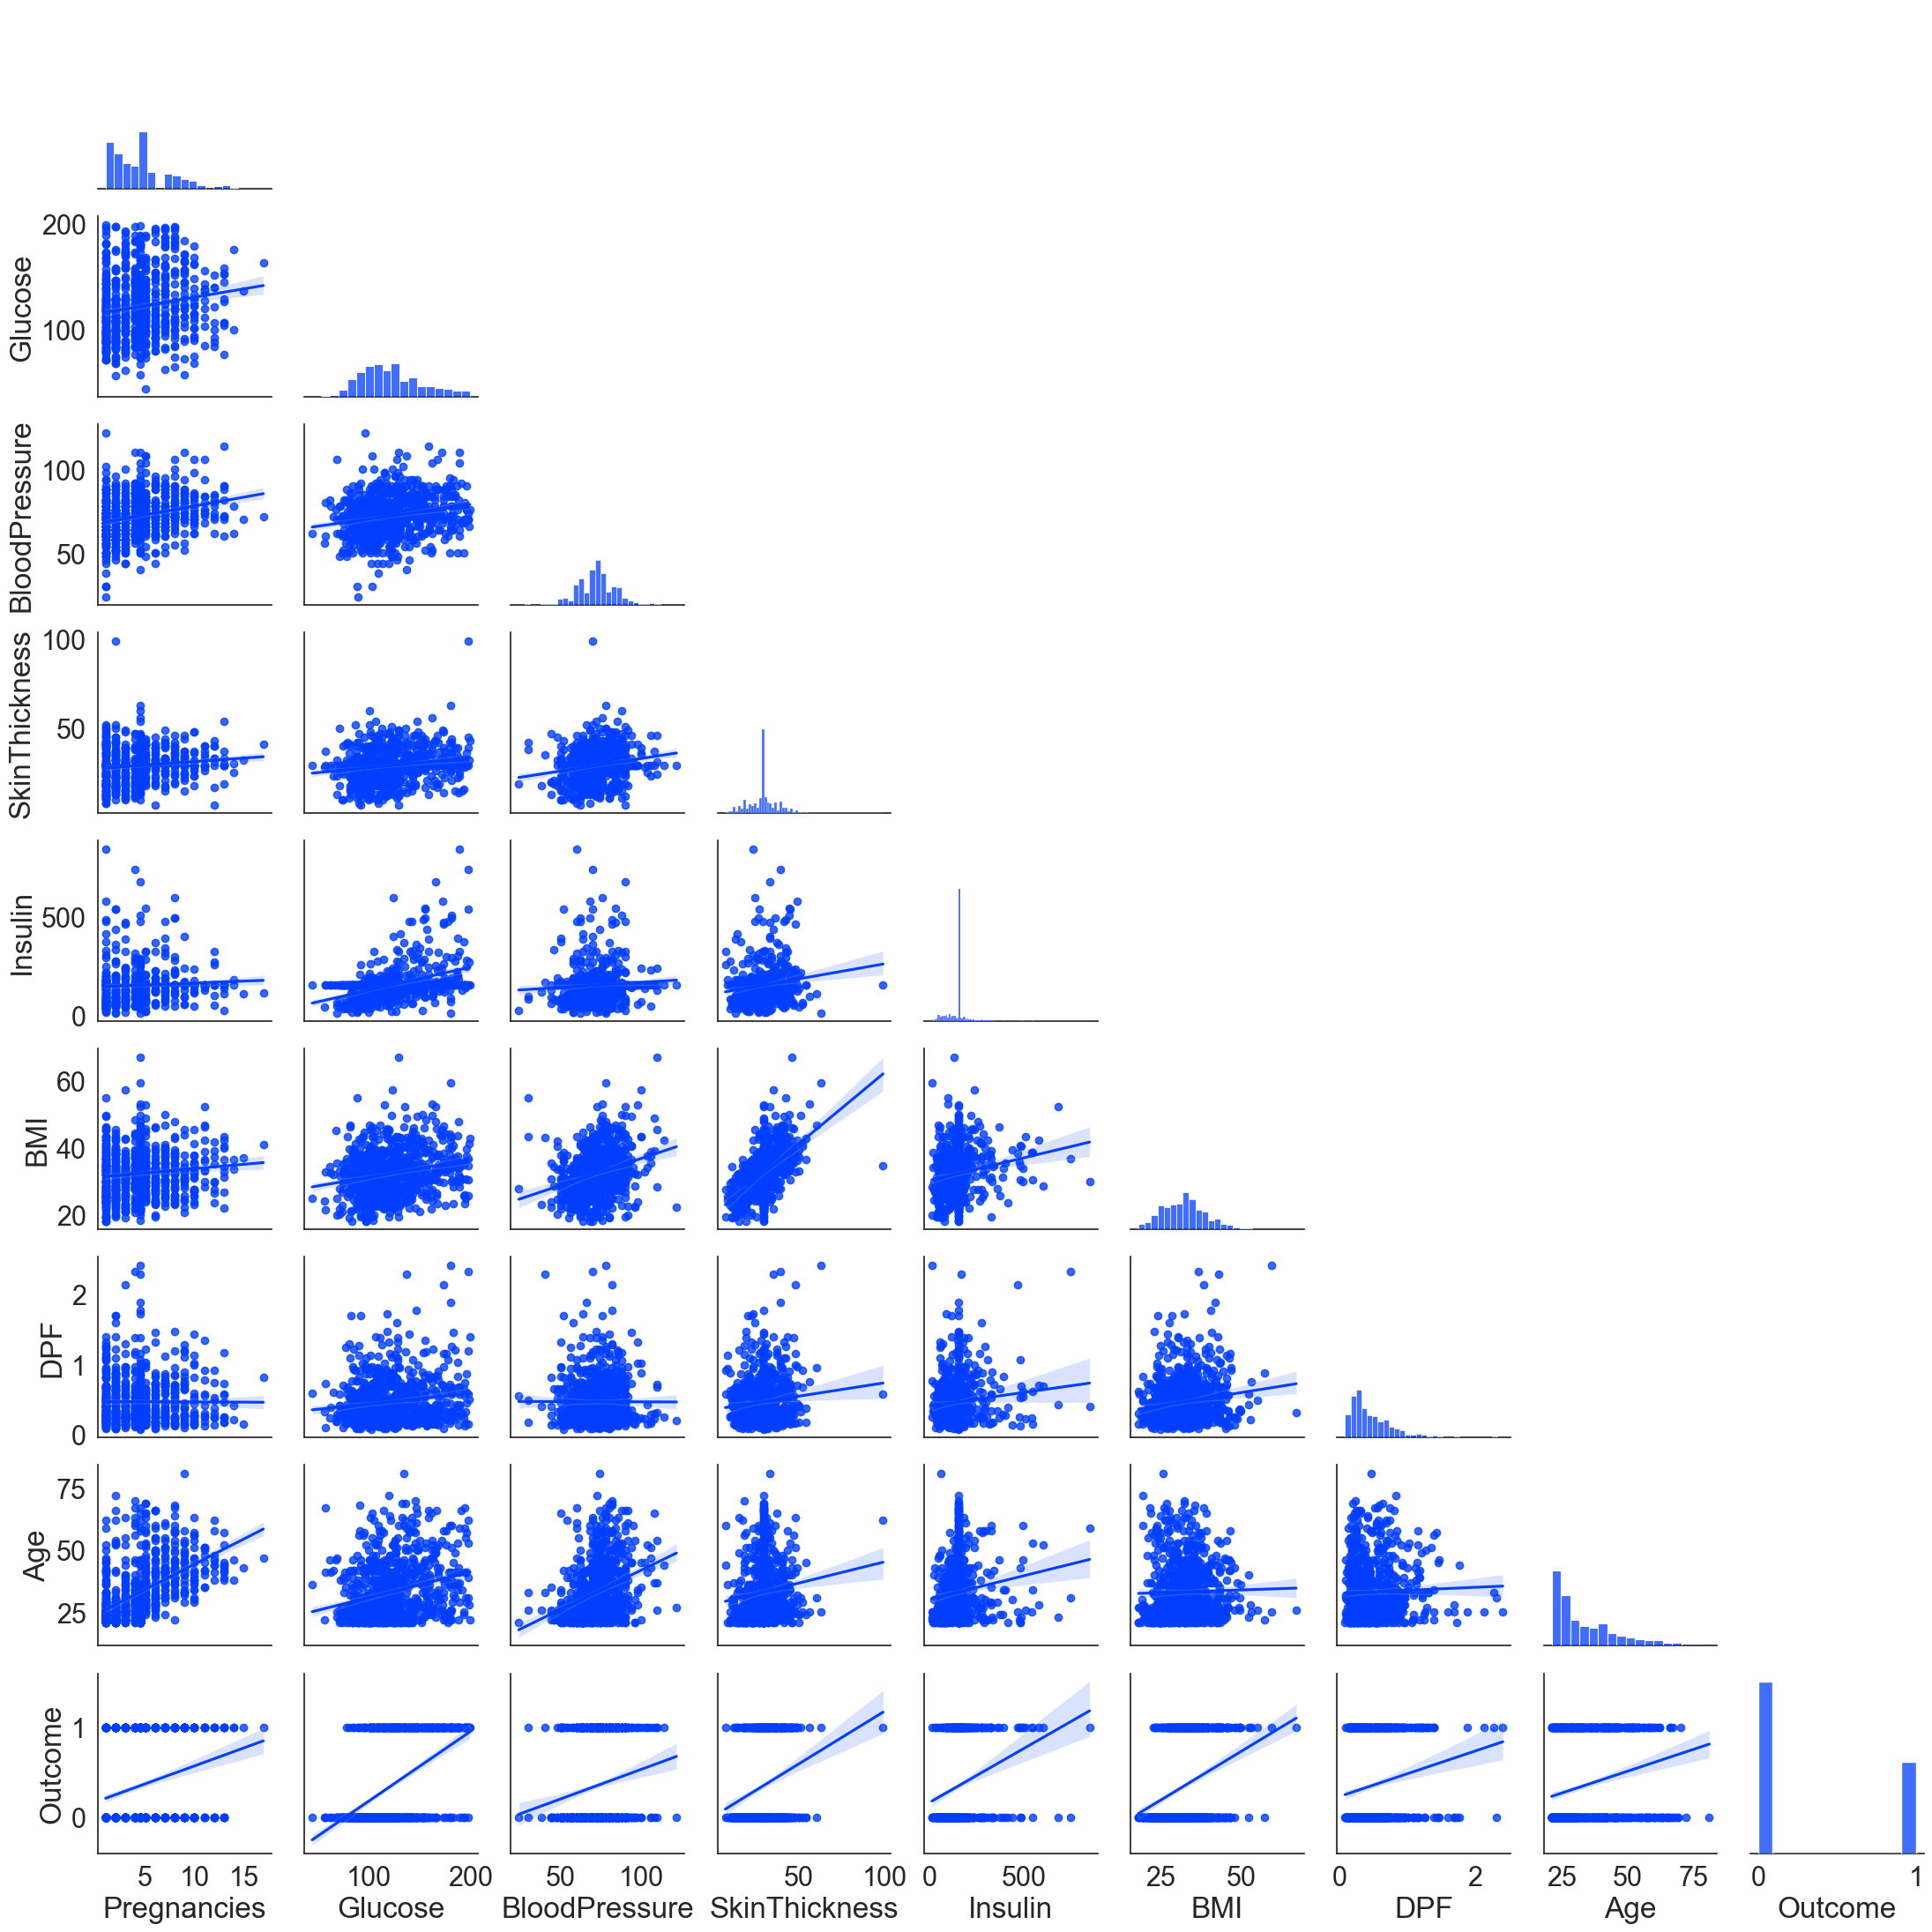

In [19]:
# Set the font scale, figure size, style, and color palette
sns.set(font_scale=2)
plt.figure(figsize=(10, 8))
sns.set_style("white")
sns.set_palette("bright")

# Create a pairplot with regression plots on the diagonal
sns.pairplot(diabetes_df, kind='reg', corner=True, palette='YlGnBu')

# Show the plot
plt.show()

# Checking features before modeling

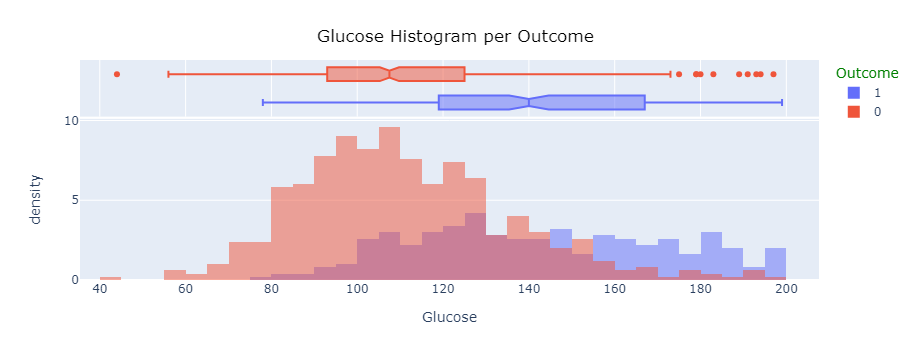

In [18]:
# Create a histogram with overlaid box plots
fig = px.histogram(diabetes_df, 
                   x="Glucose", 
                   color="Outcome", 
                   marginal="box",
                   barmode="overlay",
                   histnorm='density'
                  )

# Update layout settings for better visualization
fig.update_layout(
    title_font_color="black",
    legend_title_font_color="green",
    title={
        'text': "Glucose Histogram per Outcome",
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
)

# Show the plot
fig.show()

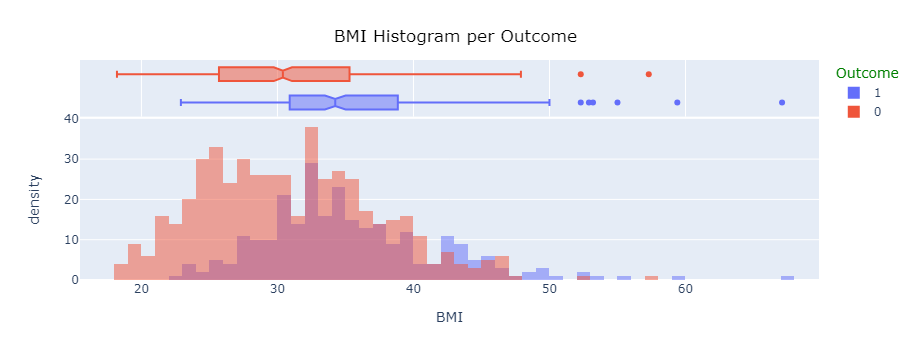

In [19]:
import plotly.express as px
fig = px.histogram(diabetes_df, x="BMI", 
                   color="Outcome", 
                   marginal="box",
                   barmode ="overlay",
                   histnorm ='density'
                  )  
fig.update_layout(
    title_font_color="black",
    legend_title_font_color="green",
    title={
        'text': "BMI Histogram per Outcome",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
)
fig.show()

# Visualizing Training Dataset after Dimension Reduction

In [53]:
X_train = diabetes_df.drop('Outcome', axis=1)
y_train = diabetes_df['Outcome']

In [21]:
from pycaret.classification import *

# Setup the PyCaret environment for classification
clf1 = setup(data=diabetes_df, 
             target='Outcome',
             preprocess=False)  # Disable automatic preprocessing

# Set the logging level to control verbosity
import logging
logging.getLogger('pycaret').setLevel(logging.ERROR)

## Comparing Models

In [22]:
# Compare top 5 models based on AUC, excluding specified models
top5 = compare_models(
    sort='AUC',          # Sort models based on AUC
    n_select=5,          # Select top 5 models
    exclude=['lightgbm', 'xgboost', 'dummy', 'svm', 'ridge', 'knn', 'dt', 'nb', 'qda']
)

## Creating Models

In [23]:
# Create and initialize CatBoost model
catboost = create_model('catboost')

# Create and initialize Random Forest model
rf = create_model('rf')

# Create and initialize Logistic Regression model
lr = create_model('lr')

# Create and initialize Linear Discriminant Analysis model
lda = create_model('lda')

# Create and initialize Gradient Boosting Classifier model
gbc = create_model('gbc')

## Interpreting Models

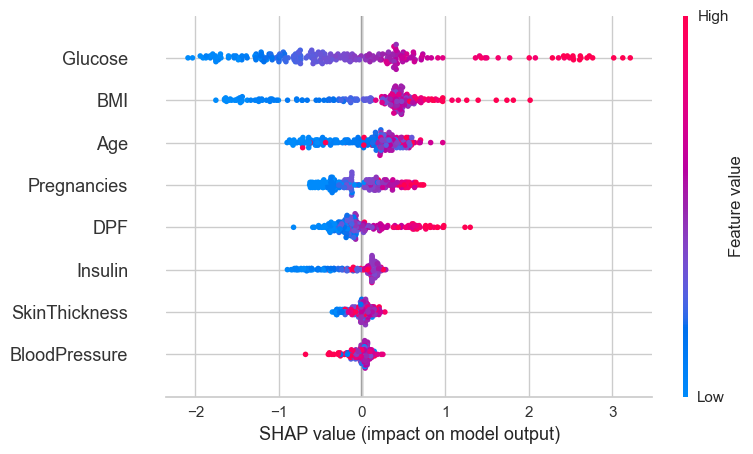

In [24]:
interpret_model(catboost)

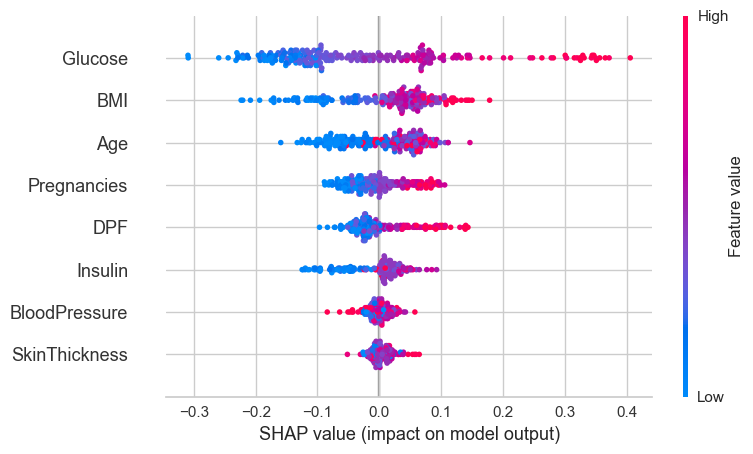

In [25]:
interpret_model(rf)

# Tuning Hyperparameters

In [26]:
tuned_catboost = tune_model(catboost, optimize = 'AUC')
tuned_rf = tune_model(rf, optimize = 'AUC')
tuned_lr = tune_model(lr, optimize = 'AUC')
tuned_lda = tune_model(lda, optimize = 'AUC')
tuned_gbc = tune_model(gbc, optimize = 'AUC')

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Fitting 10 folds for each of 10 candidates, totalling 100 fits


Fitting 10 folds for each of 10 candidates, totalling 100 fits


Fitting 10 folds for each of 10 candidates, totalling 100 fits


Fitting 10 folds for each of 10 candidates, totalling 100 fits


# Stacking

In [27]:
stack_model = stack_models(estimator_list=top5, meta_model=top5[0], optimize='AUC')

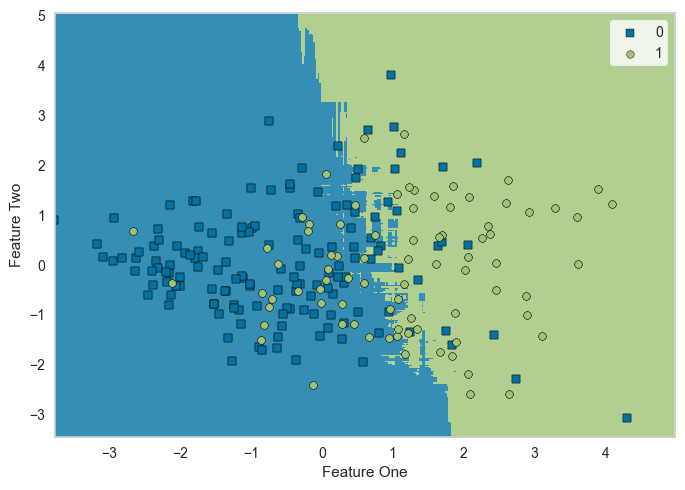

In [28]:
plt.figure(figsize=(8, 8))
plot_model(stack_model, plot='boundary')
plt.show()

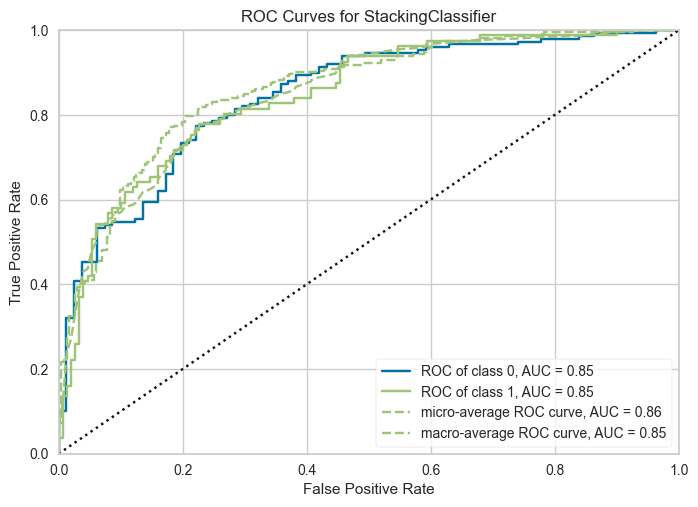

In [29]:
plt.figure(figsize=(8, 8))
plot_model(stack_model, plot='auc')
plt.show()

In [54]:
# Prediction
pred = stack_model.predict(X_test)
pred_proba = stack_model.predict_proba(X_test)[:, 1]

# Accuracy
accuracy = accuracy_score(y_test, pred)
print(f'Accuracy: {accuracy:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, pred)
print('Confusion Matrix:')
print(conf_matrix)

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, pred_proba)
print(f'ROC-AUC Score: {roc_auc:.4f}')

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Age
- DPF


In [34]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(conf_matrix, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5)
ax.set_title('Confusion Matrix (Stacking)')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.show()

NameError: name 'conf_matrix' is not defined

<Figure size 800x600 with 0 Axes>

# Soft Voting

In [35]:
blend_soft = blend_models(estimator_list = top5, optimize = 'AUC',method = 'soft')

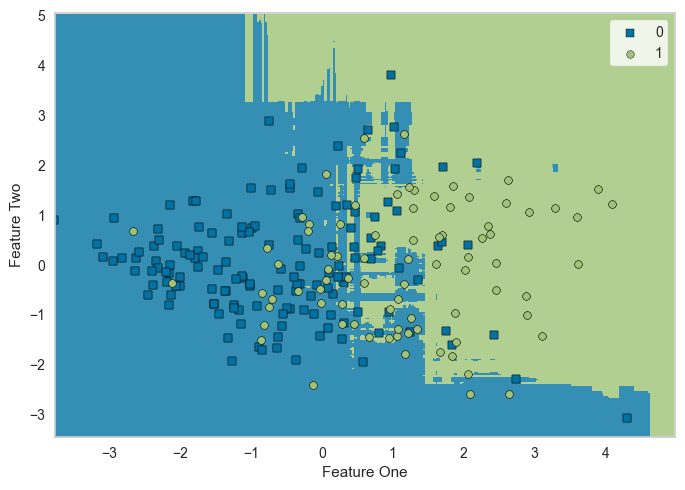

In [36]:
plt.figure(figsize=(8, 8))
plot_model(blend_soft, plot='boundary')

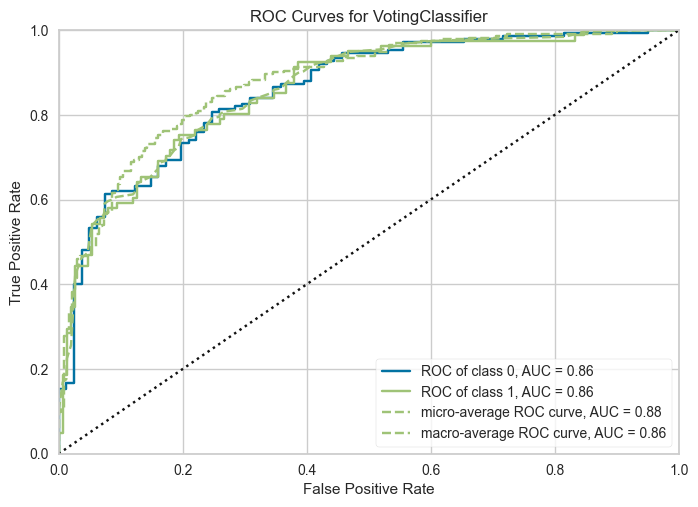

In [37]:
plt.figure(figsize=(8, 8))
plot_model(blend_soft, plot = 'auc')

In [38]:
#prediction
pred = blend_soft.predict(X_test)
pred_proba = blend_soft.predict_proba(X_test)[:,1]
#Accuracy
confusion_soft = get_clf_eval(y_test,pred,pred_proba)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- Age
- DPF


In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_soft, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Soft Blending)')

# Hard Voting

In [39]:
blend_hard = blend_models(estimator_list = top5, optimize = 'AUC',method = 'hard')

In [ ]:
plt.figure(figsize=(8, 8))
plot_model(blend_hard, plot='boundary')

# Predicting with the test dateset

In [ ]:
#prediction
pred = blend_hard.predict(X_test)
#Accuracy
confusion_hard = confusion_matrix( y_test, pred)
accuracy = accuracy_score(y_test , pred)
precision = precision_score(y_test , pred)
recall = recall_score(y_test , pred)
f1 = f1_score(y_test,pred) 
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (Hard Blending)')

# Calibrating the final model

In [ ]:
cali_model = calibrate_model(blend_soft)

# Finalizing the last model

In [ ]:
final_model = finalize_model(cali_model)

In [ ]:
plt.figure(figsize=(8, 8))
plot_model(final_model, plot='threshold')

In [ ]:
plt.figure(figsize=(8, 8))
plot_model(final_model, plot='boundary')

In [ ]:
#prediction
pred = final_model.predict(X_test)
#Accuracy
final_model = confusion_matrix( y_test, pred)
accuracy = accuracy_score(y_test , pred)
precision = precision_score(y_test , pred)
recall = recall_score(y_test , pred)
f1 = f1_score(y_test,pred) 
print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f},\
F1: {3:.4f}'.format(accuracy, precision, recall, f1))

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(confusion_hard, cmap = 'YlGnBu',annot = True, fmt='d')
ax.set_title('Confusion Matrix (final_model)')